## Imports

In [5]:
from JSU_lib import *

## Utils functions

In [2]:
def save_to_pickle(variable, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(variable, file)

def read_from_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def fix_col_names(df):
    cols = df.columns.tolist()
    new_cols = [col.strip() for col in cols]
    df.columns = new_cols
    return df
    
def reformat_sites_df(df):
    # Copy the DataFrame to avoid modifying the original data
    df_transformed = df.copy()
    
    # Step 1: Rename 'name' column
    df_transformed['name'] = df_transformed['name'].str.replace('pocket', '').astype(int)
    
    # Step 2: Convert 'residue_ids' to list of integers
    df_transformed['residue_ids'] = df_transformed['residue_ids'].apply(
        lambda x: [id_.split("_")[-1] for id_ in x.split()]
    )

    df_transformed['centre'] = list(zip(df_transformed['center_x'], df_transformed['center_y'], df_transformed['center_z']))
    
    df_transformed.drop(columns=["center_x", "center_y", "center_z"], inplace = True)
    
    df_transformed['n_aas'] = df_transformed['residue_ids'].apply(lambda x: len(x)) 
    
    # Step 3: Rename columns
    column_renames = {
        'name': 'ID',
        'rank': 'RANK',
        'score': 'score',
        'probability': 'prob',
        'sas_points': 'n_sas_points',
        'surf_atoms': 'n_surf_atoms',
        'residue_ids': 'aas'
    }
    df_transformed.rename(columns=column_renames, inplace=True)
    
    # Add a new column for site size

    df_transformed.n_sas_points = df_transformed.n_sas_points.astype(int)
    df_transformed.n_surf_atoms = df_transformed.n_surf_atoms.astype(int)
    
    return df_transformed

## Concatenating P2RANK predictions for LIGYSIS representative chains

In [4]:
rep_chains_files = read_from_pickle("./results/PDB_rep_chains_files.pkl")

LIGYSIS_rep_chains = [el.split(".")[0] for el in rep_chains_files]

preds_dir = "/Users/2394007/Documents/PHD/LOCAL/JSU_site_predictors/PROGRAMS/p2rank_2.4.1/test_output/predict_LIGYSIS_rep_chains"
all_rep_chains_LIGYSIS = [el.split(".")[0] for el in os.listdir(preds_dir) if el.endswith("_predictions.csv")]

In [5]:
len(set(all_rep_chains_LIGYSIS))

4037

In [6]:
t0 = time.time()

pred_dfs = []
ress_dfs = []

no_preds = []
no_ress = []

for i, rep_chain in enumerate(all_rep_chains_LIGYSIS):
    
    if i % 100 == 0:
        print(i)
        
    preds_path = os.path.join(preds_dir, f'{rep_chain}.clean.pdb_predictions.csv')
    ress_path = os.path.join(preds_dir, f'{rep_chain}.clean.pdb_residues.csv')
    try:
        preds_df = pd.read_csv(preds_path)
        preds_df["rep_chain"] = rep_chain
        pred_dfs.append(preds_df)
    except:
        print("Predictions not found for {}".format(rep_chain))
        no_preds.append(rep_chain)   
    try:
        ress_df = pd.read_csv(ress_path)
        ress_df["rep_chain"] = rep_chain
        ress_dfs.append(ress_df)
    except:
        print("Residues not found for {}".format(rep_chain))
        no_ress.append(rep_chain)
        
all_p2rank_preds = pd.concat(pred_dfs).reset_index(drop = True)
all_p2rank_ress = pd.concat(ress_dfs).reset_index(drop = True)

tf = time.time()
print(tf-t0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
40.656473875045776


In [7]:
print(len(no_preds))
print(len(no_ress))

0
0


In [8]:
print(len(pred_dfs)) #4037
print(len(ress_dfs))  #4037
p2rank_pred_reps = all_p2rank_preds.rep_chain.unique()
print(len(all_p2rank_ress.rep_chain.unique())) #4037
print(len(p2rank_pred_reps)) # P2Rank does not predict any sites in 552 proteins (13.67%) #3485

4037
4037
4037
3485


In [9]:
LIGYSIS_reps = read_from_pickle("./results/LIGYSIS_3448_chains.pkl")
len(set(LIGYSIS_reps).intersection(set(p2rank_pred_reps)))

2955

In [10]:
all_p2rank_preds.shape

(17009, 12)

In [11]:
all_p2rank_ress.shape

(1146997, 8)

In [12]:
all_p2rank_preds.head(3)

,name,rank,score,probability,sas_points,surf_atoms,center_x,center_y,center_z,residue_ids,surf_atom_ids,rep_chain
0,pocket1,1,23.26,0.887,125,55,144.7967,146.1258,155.3978,A_1240 A_1244 A_1245 A_1248 A_1252 A_1539 A_1...,1878 2130 2168 2199 2200 2201 2225 2226 2257 ...,7tj8_A
1,pocket2,2,20.02,0.849,146,55,137.7934,160.7019,159.7180,A_1196 A_1229 A_1232 A_1233 A_1234 A_1236 A_1...,3274 3276 3327 3328 3330 3359 3361 3362 3386 ...,7tj8_A
2,pocket3,3,18.00,0.812,104,48,143.5068,156.5458,144.0970,A_1113 A_1117 A_1120 A_1121 A_1124 A_1187 A_1...,5360 5361 5362 5392 5394 5396 5416 5425 5450 ...,7tj8_A


In [13]:
i_cols = ["rep_chain", "name", "rank", "score", "probability", "sas_points", "surf_atoms", "residue_ids", "center_x", "center_y", "center_z"]

p2rank_pockets_df = fix_col_names(all_p2rank_preds)
p2rank_pockets_df = reformat_sites_df(p2rank_pockets_df[i_cols])

In [14]:
p2rank_pockets_df.head(3)

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas
0,7tj8_A,1,1,23.26,0.887,125,55,"[1240, 1244, 1245, 1248, 1252, 1539, 1542, 154...","(144.7967, 146.1258, 155.3978)",25
1,7tj8_A,2,2,20.02,0.849,146,55,"[1196, 1229, 1232, 1233, 1234, 1236, 1237, 123...","(137.7934, 160.7019, 159.718)",23
2,7tj8_A,3,3,18.00,0.812,104,48,"[1113, 1117, 1120, 1121, 1124, 1187, 1191, 119...","(143.5068, 156.5458, 144.097)",20


In [19]:
#p2rank_pockets_df.to_pickle("./results/P2RANK_sites_V2.pkl")
#p2rank_pockets_df.to_pickle("./results/P2RANK_ress_V2.pkl")

## Calcualte RoG of P2RANK pockets

In [7]:
target_dir = './../DATA/trans_rep_chains'

In [16]:
rep_chains_sites = p2rank_pockets_df.rep_chain.unique().tolist()

In [17]:
len(rep_chains_sites) # all rep chains with P2Rank predictions

3485

In [18]:
p2rank_pockets_df.head(3)

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas
0,7tj8_A,1,1,23.26,0.887,125,55,"[1240, 1244, 1245, 1248, 1252, 1539, 1542, 154...","(144.7967, 146.1258, 155.3978)",25
1,7tj8_A,2,2,20.02,0.849,146,55,"[1196, 1229, 1232, 1233, 1234, 1236, 1237, 123...","(137.7934, 160.7019, 159.718)",23
2,7tj8_A,3,3,18.00,0.812,104,48,"[1113, 1117, 1120, 1121, 1124, 1187, 1191, 119...","(143.5068, 156.5458, 144.097)",20


In [19]:
len(p2rank_pockets_df)

17009

In [20]:
cc = [
    'label_seq_id_full', 'label_comp_id', 'type_symbol',
    'label_atom_id', 'Cartn_x', 'Cartn_y', 'Cartn_z'
]

## Using transformed structures to calculate RoG and centroid derived from residues

In [21]:
T0 = time.time()
RoG_dict = {}
centres_dict_ress = {}
errors = []
for i, rep_chain in enumerate(rep_chains_sites):
    if i % 100 == 0:
        print(i)
    pdb_path = os.path.join(target_dir, f'{rep_chain}.trans.pdb')
    df = PDBXreader(inputfile=pdb_path).atoms(format_type="pdb", excluded=())[cc].query('label_atom_id == "CA"').reset_index(drop = True)
    rep_chain_df = p2rank_pockets_df.query('rep_chain == @rep_chain')
    for _, row in rep_chain_df.iterrows():
        site_ress = row.aas
        ress_CAs = df.query('label_seq_id_full in @site_ress')
        CAs_coords = np.array(list((zip(ress_CAs.Cartn_x, ress_CAs.Cartn_y, ress_CAs.Cartn_z))))
        try:
            center_of_mass = np.mean(CAs_coords, axis=0)
            distances_squared = np.sum((CAs_coords - center_of_mass)**2, axis=1)
            radius_of_gyration = round(np.sqrt(np.mean(distances_squared)), 2)
            RoG_dict[(rep_chain, row["RANK"])] = radius_of_gyration
            centres_dict_ress[(rep_chain, row["RANK"])] = tuple([round(v, 3) for v in center_of_mass])
        except:
            raise
TF = time.time()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400


In [22]:
dTs = TF-T0

dTm = dTs/60

N_RoG = len(RoG_dict) #17009

print(N_RoG)

print(round(dTm,2))

print(round(dTs/N_RoG, 5))

17009
5.29
0.01867


In [23]:
round((N_RoG*(dTs/N_RoG))/60, 5) # 5 minutes

5.29394

In [24]:
save_to_pickle(RoG_dict, "./results/P2Rank_RoG_TRANS.pkl")

In [25]:
p2rank_pockets_df["RoG"] = p2rank_pockets_df.set_index(['rep_chain', 'RANK']).index.map(RoG_dict)

In [26]:
p2rank_pockets_df["centre_trans"] = np.nan
centres = []
errs = 0
err_chains = []
for i, row in p2rank_pockets_df.iterrows():
    try:
        centre = centres_dict_ress[(row.rep_chain, row.RANK)]
        centres.append(centre)
    except:
        errs += 1
        centres.append(np.nan)
        err_chains.append(row.rep_chain)
print(errs) # 0

0


In [27]:
p2rank_pockets_df["centre_trans"] = centres

In [28]:
p2rank_pockets_df.head(3)

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas,RoG,centre_trans
0,7tj8_A,1,1,23.26,0.887,125,55,"[1240, 1244, 1245, 1248, 1252, 1539, 1542, 154...","(144.7967, 146.1258, 155.3978)",25,10.41,"(-0.157, 0.472, -15.163)"
1,7tj8_A,2,2,20.02,0.849,146,55,"[1196, 1229, 1232, 1233, 1234, 1236, 1237, 123...","(137.7934, 160.7019, 159.718)",23,9.88,"(-0.631, 13.571, -6.52)"
2,7tj8_A,3,3,18.00,0.812,104,48,"[1113, 1117, 1120, 1121, 1124, 1187, 1191, 119...","(143.5068, 156.5458, 144.097)",20,9.47,"(11.037, 4.19, -5.943)"


## Translating and rotating P2Rank predicted pockets' centroids

In [32]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

In [34]:
p2rank_pockets_df['centre_mat'] = p2rank_pockets_df.apply(apply_rotation, axis=1)
p2rank_pockets_df['distance'] = p2rank_pockets_df.apply(calculate_distance, axis=1)

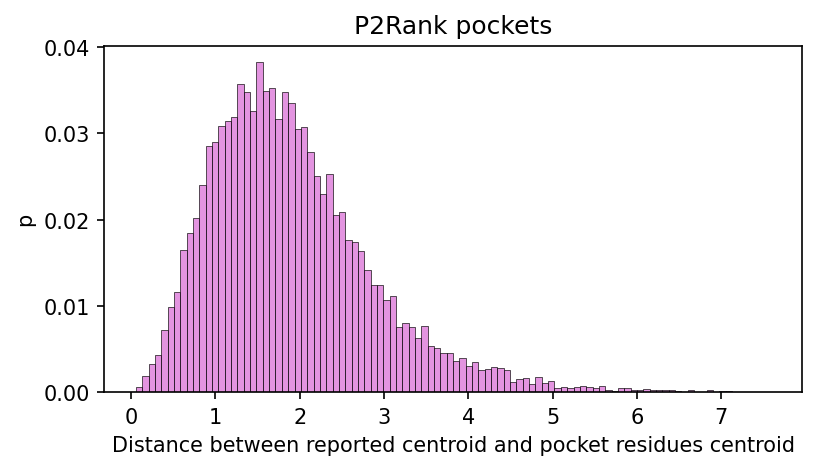

In [63]:
plt.figure(figsize = (6,3), dpi = 150)

sns.histplot(p2rank_pockets_df.distance, bins = 100, stat = "proportion", color = "orchid")
#plt.xlim(-30, 20)
plt.title("P2Rank pockets")
plt.xlabel("Distance between reported centroid and pocket residues centroid")
plt.ylabel("p")
plt.show()

In [36]:
p2rank_pockets_df.query('rep_chain == "1a52_A"')

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas,RoG,centre_trans,centre_mat,distance
15769,1a52_A,1,1,23.62,0.891,67,38,"[108, 125, 128, 129, 132, 225, 228, 229, 47, 5...","(106.6102, 14.492, 96.3564)",20,8.52,"(1.019, -8.965, -0.875)","(0.923, -9.885, -1.63)",1.194002
15770,1a52_A,2,2,2.88,0.091,44,31,"[149, 153, 27, 28, 29, 30, 57, 61, 90, 91, 94,...","(104.6059, 25.7575, 102.7596)",13,7.40,"(2.483, 0.512, 6.182)","(3.239, 0.228, 6.389)",0.833691
15771,1a52_A,3,3,1.37,0.016,24,15,"[165, 166, 169, 172, 77, 78, 81]","(80.5852, 18.8858, 96.1315)",7,6.34,"(-19.48, 7.321, -4.216)","(-19.466, 6.688, -4.142)",0.637465


In [37]:
p2rank_pockets_df.query('rep_chain == "1a52_A"')

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas,RoG,centre_trans,centre_mat,distance
15769,1a52_A,1,1,23.62,0.891,67,38,"[108, 125, 128, 129, 132, 225, 228, 229, 47, 5...","(106.6102, 14.492, 96.3564)",20,8.52,"(1.019, -8.965, -0.875)","(0.923, -9.885, -1.63)",1.194002
15770,1a52_A,2,2,2.88,0.091,44,31,"[149, 153, 27, 28, 29, 30, 57, 61, 90, 91, 94,...","(104.6059, 25.7575, 102.7596)",13,7.40,"(2.483, 0.512, 6.182)","(3.239, 0.228, 6.389)",0.833691
15771,1a52_A,3,3,1.37,0.016,24,15,"[165, 166, 169, 172, 77, 78, 81]","(80.5852, 18.8858, 96.1315)",7,6.34,"(-19.48, 7.321, -4.216)","(-19.466, 6.688, -4.142)",0.637465


In [38]:
#p2rank_pockets_df.to_pickle("./results/P2RANK_pockets_RoG_V2.pkl")

## Mapping PDB residues to UP residues

In [39]:
up_aas = {}

errors = []

for _, row in p2rank_pockets_df.iterrows():
    b = 0
    rep_chain = row.rep_chain
    site_ress = row.aas
    rank = row["RANK"]
    mapping_dict = read_from_pickle(f'./../DATA/mappings_label_full/{rep_chain}.pkl')
    site_up_aas = []
    for res in site_ress:
        try:
            site_up_aas.append(mapping_dict[str(res)]) # I think there are integers here as it is not working with AltLocs, so none are present
        except:
            errors.append(rep_chain)
            b = 1
            break
    if b ==1:
        continue
    up_aas[(rep_chain, rank)] = site_up_aas

In [40]:
len(up_aas) #16871

16871

In [41]:
len(errors) #138

138

In [42]:
errors = list(set(errors)) # 36 chains have issues with SIFTS mapping, e.g, 1nav_A. For some reason, the last 40 residues lack residue mapping to UniProt, 119 pockets
print(len(errors)) #99

99


In [43]:
save_to_pickle(errors, "./results/P2Rank_no_sifts_TRANS.pkl")

In [44]:
p2rank_pockets_df_w_sifts = p2rank_pockets_df.query('rep_chain not in @errors').copy().reset_index(drop = True)
p2rank_pockets_df_w_sifts["up_aas"] = p2rank_pockets_df_w_sifts.set_index(['rep_chain', 'RANK']).index.map(up_aas)

In [45]:
p2rank_pockets_df_w_sifts["n_up_aas"] = p2rank_pockets_df_w_sifts['up_aas'].apply(lambda x: len(x))
assert p2rank_pockets_df_w_sifts.n_aas.equals(p2rank_pockets_df_w_sifts.n_up_aas)
p2rank_pockets_df_w_sifts.drop(columns = ["n_up_aas"], inplace = True)

In [46]:
p2rank_pockets_df_w_sifts = p2rank_pockets_df_w_sifts.sort_values(by=["rep_chain", "ID"]).reset_index(drop = True)

In [47]:
#p2rank_pockets_df_w_sifts.to_pickle("./results/P2RANK_pockets_sifted_V2.pkl")

In [48]:
len(p2rank_pockets_df_w_sifts.rep_chain.unique())

3386

In [49]:
len(set(LIGYSIS_reps).intersection(set(p2rank_pockets_df_w_sifts.rep_chain.unique())))

2863

In [132]:
all_sifts_errs = ['4rh7_A',
 '2vn8_A',
 '1ux6_A',
 '4p4r_B',
 '1xsb_A',
 '6n35_M',
 '2eov_A',
 '4nff_A',
 '2eps_A',
 '4z4p_A',
 '1r79_A',
 '2ma5_A',
 '7b67_A',
 '5o9b_A',
 '5h8t_A',
 '2en8_A',
 '7ukz_D',
 '1gvl_A',
 '2w5a_A',
 '4a35_A',
 '4iwd_A',
 '6zd9_B',
 '2db6_A',
 '2mhs_A',
 '2yu4_A',
 '2rpc_A',
 '3fo5_B',
 '5lug_A',
 '2ytk_A',
 '5mkw_B',
 '4pwy_A',
 '3gvp_B',
 '6i99_A',
 '2kwn_A',
 '1nav_A',
 '5h08_A',
 '6g28_A',
 '6hdp_A',
 '2hd5_A',
 '2lau_A',
 '3ecs_A',
 '2dao_A',
 '2djb_A',
 '7knv_A',
 '2yte_A',
 '3l4v_A',
 '3fvf_B',
 '5tbn_A',
 '2k60_A',
 '1spj_A',
 '1aye_A',
 '2a5j_A',
 '2eof_A',
 '6jkg_B',
 '6cph_D',
 '5d7v_B',
 '3ikm_A',
 '4apc_B',
 '2ytf_A',
 '2nvu_B',
 '2oq5_A',
 '2i7a_A',
 '6irv_A',
 '4irp_B',
 '5fwj_B',
 '4m62_L',
 '1x05_A',
 '6r8x_A',
 '6sm1_A',
 '1a5h_B',
 '8pp8_B',
 '1kwm_A',
 '6nas_N',
 '5v54_A',
 '2jxy_A',
 '4bzy_B',
 '2ct5_A',
 '2epx_A',
 '2i0e_A',
 '6zfv_A',
 '1s5o_A',
 '2eog_A',
 '6bq1_A',
 '1ek3_A',
 '5ebz_C',
 '6u3g_B',
 '3f6u_H',
 '7ne6_A',
 '4qt6_A',
 '4jze_H',
 '4miv_C',
 '2djr_A',
 '6nvb_B',
 '2nna_A',
 '6iw6_B',
 '5mj6_B',
 '2ep0_A',
 '2yqp_A',
 '7lqd_A',
 '2zch_P',
 '2en2_A',
 '1u59_A',
 '7epm_A',
 '2gco_A',
 '7ezg_A',
 '8jjo_F',
 '3h1d_A',
 '7uw7_A',
 '7wc5_A',
 '5fb1_A',
 '2qnk_A',
 '7ktr_A',
 '2f9n_A',
 '2eor_A',
 '7kjo_B'] + ['2elr_A',
 '7krb_A',
 '2yrg_A',
 '2d8u_A',
 '2nvu_B',
 '2cot_A',
 '2eog_A',
 '1xb1_F',
 '2eps_A',
 '6zfv_A',
 '5fb1_A',
 '2gzv_A',
 '2e73_A',
 '1x05_A',
 '6sm1_A',
 '1nav_A',
 '2i8n_A',
 '6n35_M',
 '2cur_A',
 '1x5w_A',
 '6cph_D',
 '2dao_A',
 '2yu4_A',
 '2eol_A',
 '2ct7_A',
 '2eoq_A',
 '2yt9_A',
 '1j8h_D',
 '3dh1_D',
 '2epx_A',
 '2epy_A',
 '4rqr_A',
 '2eof_A',
 '2rv0_A',
 '8pp8_B',
 '2eoj_A',
 '4f7n_B',
 '6f8g_D',
 '2v0r_B',
 '2l60_A',
 '4x8y_A',
 '6gh8_A',
 '1ek3_A',
 '2eov_A',
 '2emp_A',
 '6oqk_A',
 '6g99_B',
 '2khn_A',
 '5mkw_B',
 '2l0b_A',
 '7ne6_A',
 '1wig_A',
 '2en9_A',
 '5fwj_B',
 '2l9z_A',
 '2eou_A',
 '6iw6_B',
 '1ux6_A',
 '6ze9_B',
 '2emy_A',
 '2k60_A',
 '2cqe_A',
 '1zv4_X',
 '2yrc_A',
 '2kmx_A',
 '3fo5_B',
 '4z4p_A',
 '6o5w_A',
 '4bvy_B',
 '2ct5_A',
 '2dan_A',
 '5vkj_A',
 '7b67_A',
 '2en2_A',
 '5o9b_A',
 '2ch9_A',
 '2ep3_A',
 '2eln_A',
 '2ebq_A',
 '6nas_N',
 '4p4r_B',
 '7uw7_A'] + ['2i0e_A',
 '7v6p_A',
 '1zr5_B',
 '6u3b_B',
 '6bty_B',
 '5o9b_A',
 '2en2_A',
 '6ipb_B',
 '6cph_D',
 '2d7q_A',
 '2eoj_A',
 '4mum_A',
 '5v54_A',
 '2eok_A',
 '2ytb_A',
 '6j08_A',
 '6sm1_A',
 '2d9n_A',
 '2n8z_A',
 '2l60_A',
 '6n35_M',
 '4bvy_B',
 '1wgn_A',
 '8pp8_B',
 '2h3l_A',
 '6iw6_B',
 '2epw_A',
 '5fwj_B',
 '8jjo_F',
 '4f7n_B',
 '6bq1_A',
 '5ebz_C',
 '2eop_A',
 '5t01_A',
 '2mkv_A',
 '2dao_A',
 '1y3j_A',
 '1yjt_A',
 '4wn5_A',
 '5fb1_A',
 '1xg5_B',
 '5ezd_B',
 '2epc_A',
 '1x4l_A',
 '7kjo_B',
 '6zfv_A',
 '2emv_A',
 '2en0_A',
 '2jrs_A',
 '3fo5_B',
 '2ebq_A',
 '2eqg_A',
 '6i3v_F',
 '2e73_A',
 '7u20_B',
 '3ikm_A',
 '1wyh_A',
 '4m62_L',
 '2em1_A',
 '2el5_A',
 '6b57_B',
 '2dmj_A',
 '4onh_B',
 '7klo_A',
 '1nav_A',
 '3p1m_B',
 '2ct5_A',
 '6wbp_A',
 '7ne6_A',
 '2l8e_A',
 '6lot_A',
 '2l8j_A',
 '2z80_B',
 '2a26_C',
 '2emw_A',
 '2yta_A',
 '7b67_A',
 '2emx_A',
 '3b7y_A',
 '2epy_A',
 '2gzv_A',
 '2eog_A',
 '2ch9_A',
 '7uw7_A',
 '2epu_A',
 '4z4p_A',
 '6g99_B']

In [43]:
all_sifts_errs = sorted(all_sifts_errs)

NameError: name 'all_sifts_errs' is not defined

In [136]:
len(all_sifts_errs)

284

In [140]:
un_errs = list(set(all_sifts_errs))

In [141]:
len(un_errs)

215

In [142]:
not_all_ress = ['7sol_C', '4npj_A', '3al5_C', '7pue_A', '2j1l_A', '8cm8_B', '7fbq_A', '7l3l_C', '4xbm_A', '6cz5_A', '2jhh_C', '5k55_A', '7of0_w', '6yg7_B', '6uxy_A', '8c5g_B', '6owv_A', '2bmc_E', '4y8d_A', '2xxz_B', '7kx8_B', '7b9x_A', '7yiy_E', '6eou_A', '2dq5_A', '5an4_A', '4rqk_A', '1x6v_A', '2ofw_H', '4bvy_B', '7a17_C', '5vyc_l6', '8qhr_B', '7jij_B', '2qqk_A', '5m7s_B', '5uhp_F', '6fxm_A', '5nvl_A', '2z80_B', '8g2f_A', '7tuq_B', '3pu3_B', '4b7l_B', '6mnh_A', '5o6c_A', '3fm8_D', '2buj_B', '6v9x_B', '5vhr_G', '6bh8_A', '7faq_A', '3cu0_B', '4x2q_B', '7qgp_A', '7jm5_A', '7n5u_A', '2wex_A', '7zvj_A', '7tc0_A', '2d9n_A', '3rcw_A', '4on9_A', '4u44_A', '2bva_A', '5l2n_A', '6hpo_A', '4gka_F', '5cnn_B', '7de3_A', '4wnh_D', '1hpk_A', '6szw_D', '6hge_B', '8i9l_D', '7ad7_B', '8eer_A', '1xfe_A', '5v43_B', '3mql_A', '5j7c_C', '8tdo_A', '6zl1_A', '3kxu_A', '6r8x_A', '3cd7_A', '7z38_C', '6xmh_B', '7kw7_F', '3pp0_A', '5kvt_A', '5x4w_A', '8eyr_C', '8d3y_B', '2p28_B', '2ol2_B', '4ejx_D', '3mk1_A', '2k8r_A', '2oz4_A', '1lit_A', '3t2n_A', '4x6c_A', '6i2t_A', '5o2z_B', '4oar_A', '1k8u_A', '6ujb_A', '7a2g_A', '8gx2_B', '4k86_A', '6gph_A', '5in3_B', '6zs5_A', '5fm3_A', '1xrz_A', '7t96_A', '6l88_C', '1slm_A', '8bhe_B', '7ccz_A', '3exg_1', '7mo9_E', '4iwd_A', '2hk5_A', '2xo3_A', '3zbf_A', '5q09_A', '5btq_B', '2riq_A', '4hou_B', '6eqi_A', '5vig_L', '1mfu_A', '2f9q_D', '8dfm_A', '1pkg_B', '1xap_A', '6zy6_B', '8hwl_E', '7sj3_A', '4zgy_A', '1cvj_B', '1b3o_B', '1j88_E', '1x7y_A', '3ff7_A', '7stz_D', '3edg_A', '6ze1_A', '7nyd_B', '1erh_A', '7ehm_B', '1si5_H', '5ja0_F', '3u8i_B', '7s2s_D', '8f7o_B', '2v77_B', '7vpq_E', '1auk_A', '6fwu_A', '8fd8_A', '4eno_A', '6qvs_B', '4y62_A', '1g1t_A', '3epb_A', '5l01_A', '2b4s_C', '8bvw_1', '7eiy_B', '7lbc_B', '6blw_A', '3dzu_A', '4h27_A', '5ihb_A', '4dkx_B', '3szr_A', '3bn3_A', '4okh_C', '7ukz_D', '2bxr_A', '1exz_A', '2b3u_A', '6e90_C', '6v6q_A', '7kcl_C', '4pyi_A', '1lk3_B', '7kpf_E', '4qqj_A', '3f1s_B', '1z5v_A', '7bsj_B', '5uji_B', '4l44_A', '2xx3_A', '3hnc_A', '7pwd_A', '6t36_A', '7xi9_A', '2pmv_D', '5w78_B', '2fy2_A', '3sa0_A', '2bel_A', '1imf_A', '7kja_A', '2b3o_A', '8ufp_A', '4oe5_B', '7mrv_A', '1rxt_C', '4flc_C', '4qaf_B', '5ugh_B', '2uw2_A', '8f48_A', '6npz_A', '8eqh_B', '6y7t_P', '3n9v_B', '1d6g_A', '7e58_A', '3elp_A', '5h4j_A', '7x0z_B', '7w68_C', '8a11_B', '3u8z_A', '6i6x_B', '6coz_B', '4dch_A', '2cko_A', '7zub_D', '3v6b_R', '2x1w_O', '7s77_A', '6hn3_A', '8cph_A', '2jxy_A', '8qu8_A', '1upt_G', '2wl8_B', '2dao_A', '6cht_W', '5e6m_B', '4y83_C', '7z4z_B', '5ibp_A', '2xyn_B', '8qa5_B', '5z5o_A', '7wnh_B', '4yjr_A', '6azj_B', '3v3v_A', '7cml_B', '3aln_C', '8cvx_E', '7xjj_E', '5h9q_B', '2ckj_A', '2aw5_C', '5uyx_C', '6rcg_A', '4pw8_E', '1kwp_B', '6qap_A', '4w82_A', '2px6_A', '6y0a_A', '6wkz_B', '4xeo_A', '3vbb_A', '1r5l_A', '8b9d_P', '7wr4_C', '3fit_A', '5fah_A', '7say_E', '8eza_X', '1ua2_D', '4ogr_E', '1wms_A', '8af2_A', '7vvh_A', '4jg7_A', '5uq9_G', '3fey_B', '3enm_A', '8yhh_B', '7pdv_C', '8crc_A', '2y4p_D', '6o0h_C', '3mwe_B', '1k3b_B', '3ptg_A', '1h7s_A', '4fsv_A', '2vww_A', '3zfx_A', '2cjz_A', '7d10_A', '8fht_A', '2gjs_A', '4ko8_A', '4iyr_B', '4b05_A', '5izk_B', '7jic_B', '5m5e_D', '1cf4_A', '8or4_G', '6yw7_B', '5zhx_e', '6g0i_A', '3n5c_A', '5fbl_B', '6a6k_C', '5t2c_AH', '8el7_A', '8fmn_D', '4iyp_C', '2ea6_A', '1bo1_A', '8sdw_A', '5wh1_B', '8bgu_F', '8vhl_A', '7cz5_R', '7a5o_J', '7qcn_B', '6kiu_K', '3et2_A', '1ywh_K', '3q4u_B', '6yoj_A', '1k04_A', '8flg_A', '6svq_A', '4x0f_A', '1u46_A', '7f2k_B', '4ppa_B', '6yjr_BBB', '8hag_K', '5lpk_B', '8ag2_A', '7klv_A', '6yat_B', '2m0e_A', '2lvt_A', '7mc3_A', '2y6e_E', '1uhl_B', '4lgd_C', '3zni_I', '7y5n_D', '7eu8_D', '6i9h_A', '7sid_C', '5eog_F', '7ctf_A', '6exw_C', '6d7l_B', '6pjj_C', '7fcz_B', '2odt_X', '4e5y_A', '2egq_A', '7apk_p', '3od0_A', '5j48_B', '8qjx_E', '6wcq_C', '3cc6_A', '5k5f_A', '6hyu_A', '7spd_B', '2k7z_A', '3cqv_A', '2qa5_A', '5wt7_A', '4mp7_A', '2pnr_A', '6oht_B', '2hv6_B', '5ayx_D', '3tw8_B', '7rhq_C', '6s60_A', '5fzo_B', '5hyn_K', '6n0b_A', '1jvd_B', '4qhu_C', '5mle_C', '7lk4_P', '2e0a_B', '1i1j_A', '1w73_B', '7s3v_A', '4wlh_A', '7uaf_A', '4gwm_B', '6uez_A', '2y74_A', '6cdh_A', '5v7t_A', '7n29_A', '2rfj_A', '6zdc_A', '4ae8_A', '2gh0_D', '7ewl_B', '7q1u_A', '5w0b_C', '4mtl_A', '6vrf_B', '7z4z_A', '4uyz_C', '7cm7_E', '1xg5_B', '7a3i_B', '5eak_B', '6wj2_F', '6rbj_A', '5tey_A', '8gt6_A', '6izq_D', '5ixc_B', '6ncg_A', '6t29_AAA', '4iou_C', '7nsc_D', '5goe_A', '5kso_A', '7lre_B', '5vxs_A', '5nqa_B', '6t8p_B', '3dlq_R', '7cl0_A', '2zb8_A', '7bss_A', '6u3x_A', '2b69_A', '7xj1_D', '8asn_I', '4ped_A', '6bqv_A', '7pwy_D', '1n6c_A', '6r7o_A', '3fo5_B', '4moc_A', '5ggi_A', '4bbm_B', '6lth_R', '1jsp_B', '8cij_A', '2f1z_B', '1yze_C', '7zay_B', '2xoc_A', '6d5k_C', '7e2h_D', '7e2h_E', '2xqq_A', '8or2_F', '3mxo_B', '3ooi_A', '7vdm_R', '8jgg_R', '5xws_A', '1xb1_F', '7pzc_G', '6l53_A', '5z2c_C', '6n2e_B', '4oiv_B', '6h4i_A', '2l3r_A', '6k9y_C', '4g3d_D', '2egd_B', '6ocx_C', '1yde_N', '5aws_B', '5lou_A', '4qkd_C', '6h0g_F', '6wxk_E', '6g18_v', '6r2f_D', '7yyj_B', '8bvl_A', '7ep2_B', '5x2l_B', '6yw3_A', '2l8j_A', '3jza_A', '6ki6_B', '6n2p_C', '8aly_R', '5v03_B', '6p5s_A', '7b9b_A', '3mk6_A', '3mo0_B', '6kak_A', '1p9o_A', '6vhh_B', '2exx_B', '4b7y_D', '5usr_F', '7d7r_A', '7n78_A', '4ijd_B', '4x41_A', '6ine_A', '7d3e_C', '7y49_A', '6lot_A', '7b67_A', '7m4m_A', '6eg9_B', '8s94_D', '4r2y_B', '3um7_B', '3qnf_B', '1swx_A', '4m7i_A', '7ukd_C', '7vbb_I', '2els_A', '2rv7_A', '6vfw_C', '6n3l_B', '2a7r_D', '6w5m_D', '7ogj_B', '6cwy_D', '7nv0_A', '4irp_B', '7a41_A', '7que_B', '5y18_A', '4h9n_C', '2iyb_E', '5fy4_A', '5ddm_A', '5cyp_D', '3ue2_A', '6w4c_A', '6u8v_C', '8x88_B', '8hkp_K', '2ot3_B', '7d8n_A', '8sml_D', '5iug_A', '3fmp_D', '7wts_3', '6kkr_B', '2wwu_A', '5ig3_F', '6h7x_A', '2zmf_B', '5c28_B', '3e0l_A', '7ast_A', '6gyn_C', '4zhx_B', '7v7c_E', '6crn_B', '7b5m_H', '6m49_A', '6koi_V', '6uj0_B', '8a5v_E', '5kz5_M', '6pa7_K', '2izr_A', '6oi6_A', '5a1k_B']

In [143]:
len(not_all_ress)

589

## Add pocket surfaces and volumes

In [1]:
import importlib
import JSU_lib
importlib.reload(JSU_lib)
from JSU_lib import *

In [2]:
#p2rank_pockets_df_w_sifts = pd.read_pickle("./results/P2RANK_pockets_sifted_V2.pkl")

In [50]:
master_SASA_dict = read_from_pickle("./results/master_SASA_dict.pkl")

In [51]:
p2rank_pockets_df_w_sifts_SASA = calculate_total_sasa(p2rank_pockets_df_w_sifts, master_SASA_dict)

In [52]:
vols_dict = read_from_pickle("./results/P2Rank_volumes_dict.pkl")

In [53]:
p2rank_pockets_df_w_sifts_SASA["VOL"] = p2rank_pockets_df_w_sifts_SASA.set_index(['rep_chain', 'ID']).index.map(vols_dict)

In [55]:
p2rank_pockets_df_w_sifts_SASA.query('VOL != VOL')

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas,RoG,centre_trans,centre_mat,distance,up_aas,SASA,VOL


In [57]:
p2rank_pockets_df_w_sifts_SASA

,rep_chain,ID,RANK,score,prob,n_sas_points,n_surf_atoms,aas,centre,n_aas,RoG,centre_trans,centre_mat,distance,up_aas,SASA,VOL
0,1a52_A,1,1,23.62,0.891,67,38,"[108, 125, 128, 129, 132, 225, 228, 229, 47, 5...","(106.6102, 14.492, 96.3564)",20,8.52,"(1.019, -8.965, -0.875)","(0.923, -9.885, -1.63)",1.194002,"[404, 421, 424, 425, 428, 521, 524, 525, 343, ...",475.28,469
1,1a52_A,2,2,2.88,0.091,44,31,"[149, 153, 27, 28, 29, 30, 57, 61, 90, 91, 94,...","(104.6059, 25.7575, 102.7596)",13,7.40,"(2.483, 0.512, 6.182)","(3.239, 0.228, 6.389)",0.833691,"[445, 449, 323, 324, 325, 326, 353, 357, 386, ...",482.33,376
2,1a52_A,3,3,1.37,0.016,24,15,"[165, 166, 169, 172, 77, 78, 81]","(80.5852, 18.8858, 96.1315)",7,6.34,"(-19.48, 7.321, -4.216)","(-19.466, 6.688, -4.142)",0.637465,"[461, 462, 465, 468, 373, 374, 377]",462.42,174
3,1a5h_B,1,1,11.25,0.602,77,52,"[149, 197, 198, 199, 200, 201, 203, 221, 222, ...","(15.5722, 56.1143, 30.3067)",24,9.44,"(2.415, 2.985, -6.743)","(2.88, 4.115, -7.885)",1.672510,"[459, 507, 508, 509, 510, 511, 513, 531, 532, ...",728.93,958
4,1a5h_B,2,2,5.87,0.287,74,34,"[126, 127, 128, 130, 160, 161, 163, 166, 176, ...","(21.6374, 54.232, 12.6223)",16,8.22,"(-8.863, 12.308, 2.254)","(-8.888, 12.743, 3.953)",1.753981,"[436, 437, 438, 440, 470, 471, 473, 476, 486, ...",830.75,556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16370,8y6o_H,1,1,0.58,0.000,3,5,"[102, 132, 134, 94]","(264.9817, 302.9044, 260.9228)",4,5.34,"(-6.068, -8.506, -3.618)","(-6.634, -7.233, -1.756)",2.325495,"[102, 132, 134, 94]",77.55,81
16371,8yhh_B,1,1,5.99,0.295,52,29,"[109, 110, 112, 113, 114, 115, 120, 234, 235, ...","(15.0731, 33.0588, 32.35)",12,7.22,"(6.129, -5.132, -6.005)","(7.65, -6.803, -7.027)",2.479953,"[107, 108, 110, 111, 112, 113, 118, 232, 233, ...",533.95,755
16372,8yhh_B,2,2,5.84,0.285,78,37,"[100, 159, 161, 163, 189, 192, 195, 196, 197, ...","(4.5806, 36.126, 54.6956)",22,8.85,"(2.521, 13.257, 5.168)","(3.022, 14.274, 5.348)",1.147907,"[98, 157, 159, 161, 187, 190, 193, 194, 195, 1...",715.45,831
16373,8yhh_B,3,3,1.11,0.008,14,9,"[27, 340, 41, 43, 45, 76]","(17.0071, 46.871, 23.0181)",6,5.35,"(-2.655, -18.93, -6.212)","(-4.722, -18.133, -7.424)",2.525201,"[25, 338, 39, 41, 43, 74]",162.21,164


In [58]:
p2rank_pockets_df_w_sifts_SASA.to_pickle("./results/P2Rank_pockets_DEF_TRANS.pkl")

In [14]:
for _i, row in combined_SASA_df.iterrows():
    RoG = row.RoG
    rep_chain = row.rep_chain
    aas = row.aas
    ID = row.ID
    if RoG > 19:
        print(f"{rep_chain}_{ID}: {RoG} --> {'+'.join(aas)}")

2obd_A_1: 19.51 --> 11+125+127+129+13+136+138+15+187+191+194+195+197+198+199+20+201+202+205+206+207+208+211+215+228+23+230+232+236+24+26+261+263+265+269+27+270+273+274+277+282+283+284+285+287+292+295+296+30+31+321+323+324+325+329+331+338+340+342+344+346+367+369+371+373+375+380+382+412+413+416+417+418+420+421+422+425+428+429+432+433+436+437+438+440+441+443+446+448+450+455+457+459+461+463+467+468+471+74+82+84


## Creating prank rescore fpocket script

In [26]:
header = """
# Dataset for rescoring fpocket 4 predictions on 3,448 LIGYSIS chains
# (predictions generated with fpocket 4.0 on "./trans_rep_chains" single-chain structures)
#

PARAM.PREDICTION_METHOD=fpocket


HEADER: prediction protein
"""
# trans_rep_chains/1a52_A.trans_out/1a52_A.trans_out.pdb  trans_rep_chains/1a52_A.trans.pdb

In [3]:
ds_path = './../DATA/prank_rescore_fpocket_ALL.ds'

In [12]:
target_files = os.listdir(target_dir)

out_files = sorted([el for el in target_files if el.endswith("_out")])

pdb_files = sorted([el for el in target_files if el.endswith(".pdb")])

In [13]:
print(len(out_files))
print(len(pdb_files))

4435
4435


In [14]:
out_files[:5]

['1a52_A.trans_out',
 '1a5h_B.trans_out',
 '1a9w_E.trans_out',
 '1ags_B.trans_out',
 '1aii_A.trans_out']

In [15]:
pdb_files[:5]

['1a52_A.trans.pdb',
 '1a5h_B.trans.pdb',
 '1a9w_E.trans.pdb',
 '1ags_B.trans.pdb',
 '1aii_A.trans.pdb']

In [27]:
ls = []
for i, out_f in enumerate(out_files):
    out_f_pdb = out_f.split(".")[0]
    pdb_f_pdb = pdb_files[i].split(".")[0]
    assert out_f_pdb == pdb_f_pdb

    out_f_dir = os.path.join(target_dir, out_f)
    out_path = os.path.join(f'trans_rep_chains/{out_f}', f'{out_f_pdb}.trans_out.pdb')
    assert os.path.isfile(os.path.join(out_f_dir, f'{out_f_pdb}.trans_out.pdb'))
    l = f'{out_path} {os.path.join("trans_rep_chains", pdb_files[i])}'
    print(l)
    #break

trans_rep_chains/1a52_A.trans_out/1a52_A.trans_out.pdb trans_rep_chains/1a52_A.trans.pdb
trans_rep_chains/1a5h_B.trans_out/1a5h_B.trans_out.pdb trans_rep_chains/1a5h_B.trans.pdb
trans_rep_chains/1a9w_E.trans_out/1a9w_E.trans_out.pdb trans_rep_chains/1a9w_E.trans.pdb
trans_rep_chains/1ags_B.trans_out/1ags_B.trans_out.pdb trans_rep_chains/1ags_B.trans.pdb
trans_rep_chains/1aii_A.trans_out/1aii_A.trans_out.pdb trans_rep_chains/1aii_A.trans.pdb
trans_rep_chains/1aqd_K.trans_out/1aqd_K.trans_out.pdb trans_rep_chains/1aqd_K.trans.pdb
trans_rep_chains/1au1_A.trans_out/1au1_A.trans_out.pdb trans_rep_chains/1au1_A.trans.pdb
trans_rep_chains/1aue_B.trans_out/1aue_B.trans_out.pdb trans_rep_chains/1aue_B.trans.pdb
trans_rep_chains/1auk_A.trans_out/1auk_A.trans_out.pdb trans_rep_chains/1auk_A.trans.pdb
trans_rep_chains/1aye_A.trans_out/1aye_A.trans_out.pdb trans_rep_chains/1aye_A.trans.pdb
trans_rep_chains/1aze_A.trans_out/1aze_A.trans_out.pdb trans_rep_chains/1aze_A.trans.pdb
trans_rep_chains/1b1c